# Robot Dynamics Model Training
This notebook trains a robot dynamics model using the architecture specified. The model will predict the next state of the robot given a sequence of previous states and actions.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure matplotlib inline mode for Jupyter
%matplotlib inline

### Load the Dataset

In [2]:
# Load the dataset
file_path = 'tile_data_v2.csv'  # replace with the actual path to your dataset
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,timestamp,x,y,z,yaw,v_horizontal,v_vertical,accel,steer
0,2048.004209,452197.462912,3.949667e+06,88.468085,-0.390413,0.011836,0.030021,0.0,-38.0
1,2048.104465,452197.467826,3.949667e+06,88.463231,-0.393374,0.038694,-0.091738,0.0,-38.0
2,2048.207218,452197.465972,3.949667e+06,88.469801,-0.385135,0.049873,0.043076,0.0,-38.0
3,2048.304435,452197.465861,3.949667e+06,88.467945,-0.380474,0.034952,-0.009294,0.0,-38.0
4,2048.404340,452197.465777,3.949667e+06,88.468571,-0.386001,0.013054,-0.024935,0.0,-38.0


### Data Preprocessing
We will create input sequences of length `h` for both the state and action variables, and output sequences for the corresponding next state.

In [3]:
# Extract state and action data
state_columns = ['x', 'y', 'yaw', 'v_horizontal', 'v_vertical']
action_columns = ['accel', 'steer']

states = data[state_columns].values
actions = data[action_columns].values

# Create sequences with history length h
h = 10  # history length
input_sequences = []
output_sequences = []

for i in range(len(states) - h):
    input_seq = np.concatenate((states[i:i+h], actions[i:i+h]), axis=1).flatten()
    output_seq = states[i+h]  # the next state to predict
    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Convert to PyTorch tensors
inputs = torch.tensor(input_sequences, dtype=torch.float32)
outputs = torch.tensor(output_sequences, dtype=torch.float32)

inputs.shape, outputs.shape  # Check the shapes


(torch.Size([3118, 70]), torch.Size([3118, 5]))

### Define the Model
The model architecture is as follows:

In [9]:
# Define the model
class RobotDynamicsModel(nn.Module):
    def __init__(self, input_size):
        super(RobotDynamicsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2 * input_size)
        self.fc2 = nn.Linear(2 * input_size, 4 * input_size)
        self.fc3 = nn.Linear(4 * input_size, 6 * input_size)
        self.fc4 = nn.Linear(6 * input_size, 2 * input_size)
        self.output_layer = nn.Linear(2 * input_size, len(state_columns))  # Output size is |x| = 3

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = h * (len(state_columns) + len(action_columns))  # h * (|x| + |a|)
model = RobotDynamicsModel(input_size)
model

RobotDynamicsModel(
  (fc1): Linear(in_features=70, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=280, bias=True)
  (fc3): Linear(in_features=280, out_features=420, bias=True)
  (fc4): Linear(in_features=420, out_features=140, bias=True)
  (output_layer): Linear(in_features=140, out_features=5, bias=True)
)

### Training the Model
We'll now train the model using the Mean Squared Error (MSE) loss function and the Adam optimizer.

In [27]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model = RobotDynamicsModel(input_size).to(device)

# Move the data to the GPU
inputs = inputs.to(device)
outputs = outputs.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
epochs = 100000
loss_threshold = 10  # Define your loss threshold
min_loss = float('inf')
losses = []  # To store the loss values
filtered_losses = []  # To store non-outlier loss values for plotting



In [28]:
# Train the model
for epoch in range(epochs):
    optimizer.zero_grad()

    predictions = model(inputs)  # Predictions are now on GPU
    loss = criterion(predictions, outputs)  # Loss is computed on GPU
    loss.backward()  # Backpropagation on GPU
    optimizer.step()

    current_loss = loss.item()
    losses.append(current_loss)
    
    # Outlier detection: filter out any loss value above a certain threshold
    if current_loss <= loss_threshold:
        filtered_losses.append(current_loss)

    else:
        # print(predictions.shape, outputs.shape)
        pass

    # Save the model if loss is below the threshold and is the minimum observed
    if current_loss < loss_threshold and current_loss < min_loss:
        min_loss = current_loss
        torch.save(model.state_dict(), 'best_model_below_threshold.pth')
        print(f'Model saved at epoch {epoch + 1} with loss: {current_loss:.4f}')
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}')

Epoch [10/100000], Loss: 2830183170048.0000
Epoch [20/100000], Loss: 2481241980928.0000
Epoch [30/100000], Loss: 1992459550720.0000
Epoch [40/100000], Loss: 1312099139584.0000
Epoch [50/100000], Loss: 544867123200.0000
Epoch [60/100000], Loss: 64767680512.0000
Epoch [70/100000], Loss: 42582917120.0000
Epoch [80/100000], Loss: 8727603200.0000
Epoch [90/100000], Loss: 5161734656.0000
Epoch [100/100000], Loss: 2212307200.0000
Epoch [110/100000], Loss: 163283136.0000
Epoch [120/100000], Loss: 353987776.0000
Epoch [130/100000], Loss: 32281926.0000
Epoch [140/100000], Loss: 34303268.0000
Epoch [150/100000], Loss: 6817307.0000
Epoch [160/100000], Loss: 4106782.5000
Epoch [170/100000], Loss: 771038.6875
Epoch [180/100000], Loss: 507101.3438
Epoch [190/100000], Loss: 137952.4688
Epoch [200/100000], Loss: 35279.1406
Epoch [210/100000], Loss: 30286.7422
Epoch [220/100000], Loss: 1491.0051
Epoch [230/100000], Loss: 4861.3838
Epoch [240/100000], Loss: 1132.2386
Epoch [250/100000], Loss: 1050.8783
E

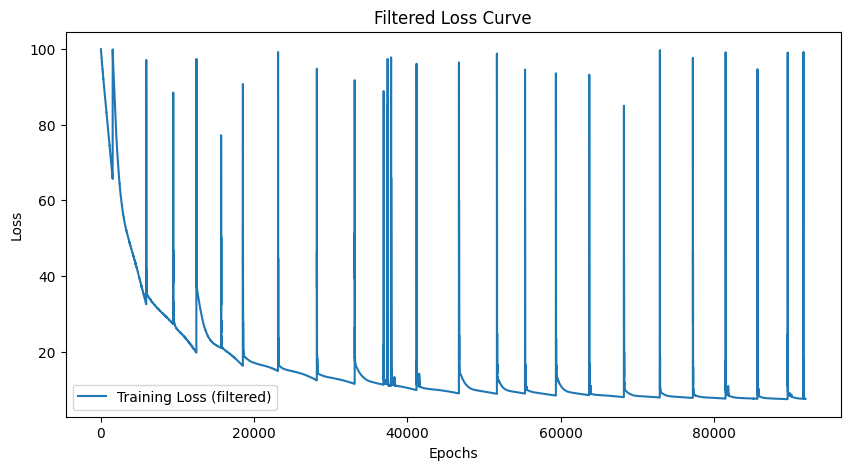

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_losses, label='Training Loss (filtered)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Filtered Loss Curve')
plt.legend()
plt.show()
